<a href="https://colab.research.google.com/github/MohanPanga/dandelion_deep_learning/blob/main/dandelionModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://space-rocks-bucket.s3.amazonaws.com/archive+(4).zip"
data_dir1 = tf.keras.utils.get_file('archive+(4)', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir1)

3786375168/3786364206 [==============================] - 58s 0us/step


In [3]:
#Set the directory for the images in the extracted zip file
data_dir = pathlib.Path('/root/.keras/datasets/Images')

In [4]:
!ls /root/.keras/datasets/Images

dandelion  other


In [5]:
# Show list of files extracted 
list(data_dir.glob('*/*'))

[PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1255.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1133.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6096.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1248.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_5427.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1171.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6755.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6763.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_3934.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6092.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_5415.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6681.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_3911.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6735.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_5446.jp

In [6]:
list(data_dir.glob('*/*'))

[PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1255.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1133.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6096.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1248.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_5427.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_1171.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6755.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6763.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_3934.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6092.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_5415.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6681.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_3911.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_6735.jpg'),
 PosixPath('/root/.keras/datasets/Images/dandelion/IMG_5446.jp

In [7]:
#Content of copied dataset 1262 images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1262


In [8]:
# Assigning images to the dandelion and other lists . Show sample image per list
dandelion = list(data_dir.glob('dandelion/*'))
#PIL.Image.open(str(dandelion[7]))

In [9]:
#PIL.Image.open(str(dandelion[7]))

In [10]:
other = list(data_dir.glob('other/*'))
#PIL.Image.open(str(other[0]))

In [11]:
#Define the parameters for the loaders. setting size to 180 and using standard 32 for batch
batch_size = 32
img_height = 540
img_width = 540

In [12]:
#Split dataset for training : use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1262 files belonging to 2 classes.
Using 1010 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1262 files belonging to 2 classes.
Using 252 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['dandelion', 'other']


In [15]:
# show nine images from the training datase
#import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 10))
#for images, labels in train_ds.take(1):
 # for i in range(9):
  #  ax = plt.subplot(3, 3, i + 1)
   # plt.imshow(images[i].numpy().astype("uint8"))
   # plt.title(class_names[labels[i]])
   # plt.axis("off")

In [16]:
# model using these datasets by passing them to Model.fit
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 540, 540, 3)
(32,)


In [17]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
#Standardize the data
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# **CREATING THE MODEL**

In [20]:
#use sequential model
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [21]:
#compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 540, 540, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 540, 540, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 270, 270, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 270, 270, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 135, 135, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 135, 135, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 67, 67, 64)        0

In [23]:
#train the model
epochs=7
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
32/32 [==============================] - 64s 1s/step - loss: 1.8635 - accuracy: 0.4802 - val_loss: 0.6934 - val_accuracy: 0.4405
Epoch 2/7
32/32 [==============================] - 10s 324ms/step - loss: 0.6897 - accuracy: 0.5782 - val_loss: 0.6720 - val_accuracy: 0.5794
Epoch 3/7
32/32 [==============================] - 10s 323ms/step - loss: 0.6620 - accuracy: 0.6218 - val_loss: 0.7111 - val_accuracy: 0.4921
Epoch 4/7
32/32 [==============================] - 10s 323ms/step - loss: 0.5950 - accuracy: 0.6861 - val_loss: 0.7142 - val_accuracy: 0.5556
Epoch 5/7
32/32 [==============================] - 10s 326ms/step - loss: 0.4387 - accuracy: 0.8040 - val_loss: 0.7001 - val_accuracy: 0.5317
Epoch 6/7
32/32 [==============================] - 10s 324ms/step - loss: 0.4243 - accuracy: 0.8851 - val_loss: 0.9383 - val_accuracy: 0.5357
Epoch 7/7
32/32 [==============================] - 10s 325ms/step - loss: 0.2323 - accuracy: 0.9139 - val_loss: 1.1612 - val_accuracy: 0.5714


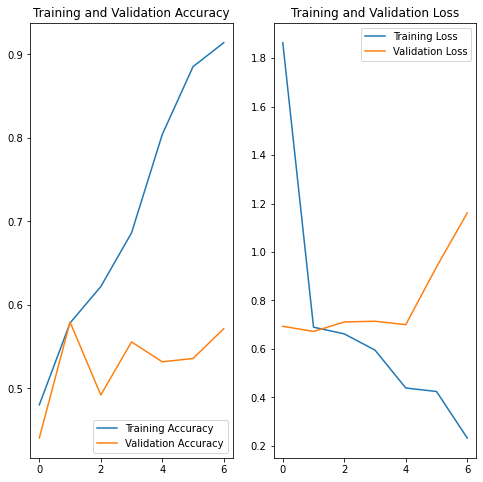

In [24]:
#Visualize training results by creating plots of loss and accuracy on the training and validation sets:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#from google.colab import files
#uploaded = files.upload()

In [26]:
from google.colab import files

model.save("DandelionModel2.h5")
files.download("DandelionModel2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>